# Bestimmen des optimalen relativen Startpunktes mittels k-Means

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

colors = {0:'tab:blue',1:'tab:orange',2:'tab:green'}

#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}

#matplotlib.rc('font', **font)

In [2]:
with open('data.pickle', 'rb') as handle:
    data = pickle.load(handle)

df = pd.read_pickle("data.pickle")

In [15]:
#Create a new Datafram for start and endpoints of spiral search only
start_end_points = pd.DataFrame()
start_end_points["run"] = []
start_end_points["segment"] = []
start_end_points["component"] = []
start_end_points["start_or_end"] = []
start_end_points["point_x"] = []
start_end_points["point_y"] = []
start_end_points["point_z"] = []


<AxesSubplot:xlabel='point_x', ylabel='point_y'>

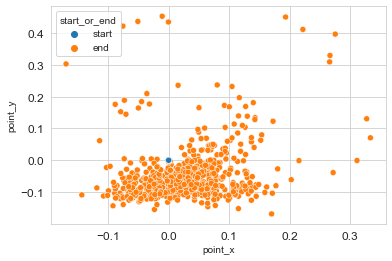

In [18]:
# Starting and endpoints of all runs - Spiral search only - relative (delta) values
# Clear dataframe
start_end_points = start_end_points.iloc[0:0]
for run in df['run'].unique():

    df_run = df[df["run"] == run]

    # Iterate over Components (1 component has 3 segments)
    for i in range(int(len(df_run["segment"].unique())/3)):
        #print("i: " + str(i))
        for index, seg in enumerate(df_run["segment"].unique()[i*3:(i+1)*3]):#[0:i*3]):
            if not index%3 == 2:
                continue
            #print("-----")
            #print(str(index) + ", " + str(index%3) + ", Seg: " + str(seg))
            t = df_run[df_run["segment"]==seg]

            # We set the startpoint as 0,0,0 for x,y and z direction
            new_row_start = {'run':'0', 'segment':seg, 'component':i+1, 'start_or_end':'start', 'point_x':0, 'point_y':0, 'point_z':0}
            # We now calculate the relative endpoint value by subtracting the startponit form the endpoint separately for x,y and z direction.
            new_row_end = {'run':'0', 'segment':seg, 'component':i+1, 'start_or_end':'end', 'point_x':t["pos_x"].iloc[-1]-t["pos_x"].iloc[0], 'point_y':t["pos_y"].iloc[-1]-t["pos_y"].iloc[0], 'point_z':t["pos_z"].iloc[-1]-t["pos_z"].iloc[0]}

            start_end_points = start_end_points.append(new_row_start, ignore_index=True)
            start_end_points = start_end_points.append(new_row_end, ignore_index=True)

sns.scatterplot(data=start_end_points, x="point_x", y="point_y", hue="start_or_end")

In [38]:
relative_end = start_end_points[start_end_points['start_or_end'] == 'end']

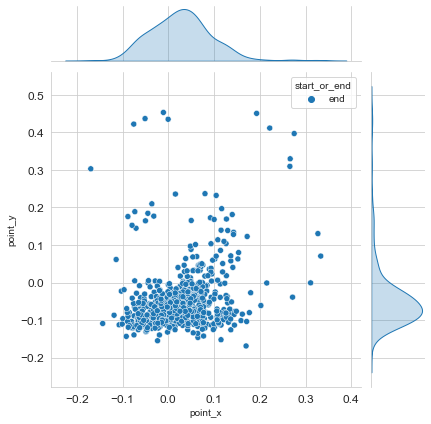

In [39]:
sns.jointplot(data=relative_end, x="point_x", y="point_y", hue="start_or_end")

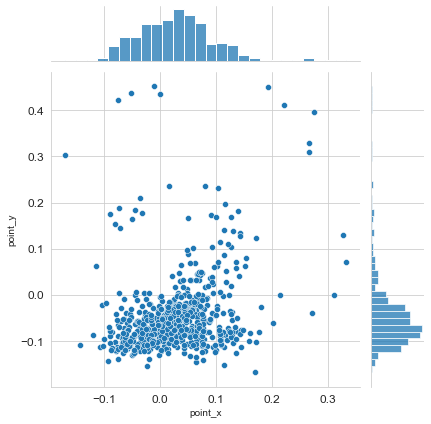

In [40]:
sns.jointplot(data=relative_end, x="point_x", y="point_y")

<AxesSubplot:xlabel='point_x', ylabel='Count'>

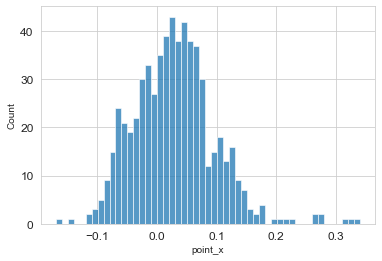

In [41]:
sns.histplot(data=relative_end, x="point_x", binwidth=0.01)

<AxesSubplot:xlabel='point_y', ylabel='Count'>

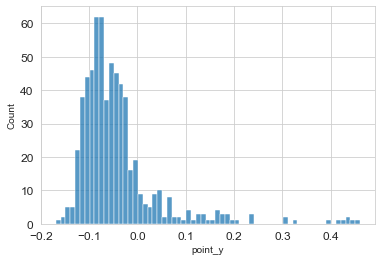

In [42]:
sns.histplot(data=relative_end, x="point_y", binwidth=0.01)

Wie in den Histogrammen ersichtlich wird, befinden sich die Mehrzahl aller Endpunkte südostlich - also positiv auf der x-Achse und negativ auf der y-Achse - des Startpunkts bei der Betrachtung des 2-Dimensionalen Streudiagramms

<AxesSubplot:xlabel='point_x', ylabel='point_y'>

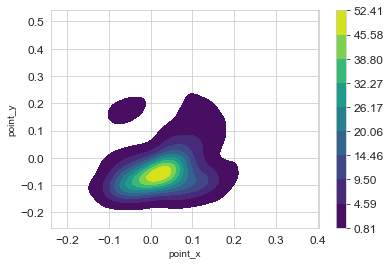

In [59]:
sns.kdeplot(data=relative_end, x="point_x", y="point_y", cbar=True, fill=True, cmap="viridis")

<AxesSubplot:xlabel='point_x', ylabel='point_y'>

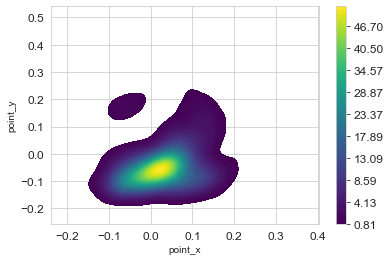

In [62]:
sns.kdeplot(data=relative_end, x="point_x", y="point_y", fill=True, levels=100, cmap="viridis", cbar=True)

In [66]:
kmeans_data = relative_end[["point_x","point_y"]].to_numpy()

In [63]:
# Kmeans -> which K? -> elbow method

from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [113]:
elbow = calculate_WSS(kmeans_data, 20)

C:\Users\Andreas Mai\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


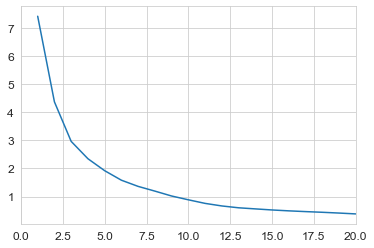

In [114]:
plot = sns.lineplot(y=elbow,x=range(1,len(elbow)+1))
plot.set(xlim=(0,20))
plt.show()

Die Ellenbogenmethode zum bestimmen des optimalen k für den k-Means Algorithmus zeigt leider keinen eindeutigen "Ellenbogen"
Daher wurden des weiteren die Silhouettenkoeffizienten berechnet

In [117]:
# silhouette

from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(kmeans_data)
  labels = kmeans.labels_
  sil.append(silhouette_score(kmeans_data, labels, metric = 'euclidean'))


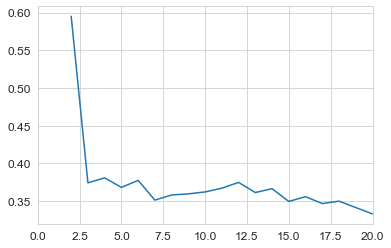

In [120]:
plot = sns.lineplot(y=sil,x=range(2,len(sil)+2))
plot.set(xlim=(0,20))
plt.show()

Da der maximale Silhouettenkoeffizient bei 2 liegt, ist das optimale k für den k-Means 2 (oder 1, wenn von nur einem einzigen Cluster ausgegangen wird)

In [ ]:
kmeans2 = KMeans(n_clusters = 2).fit(kmeans_data)
kmeans1 = KMeans(n_clusters = 1).fit(kmeans_data)

In [148]:
display(kmeans2.cluster_centers_)
display(kmeans1.cluster_centers_)

array([[ 0.01997886, -0.0663818 ],
       [ 0.09221749,  0.13850815]])

array([[ 0.02842986, -0.0424123 ]])

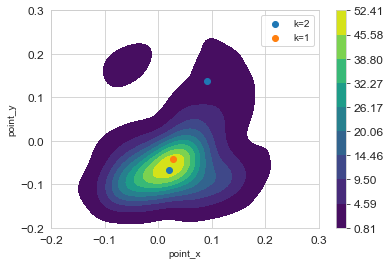

In [149]:
x = np.transpose(kmeans2.cluster_centers_)[0]
y = np.transpose(kmeans2.cluster_centers_)[1]
x1 = kmeans1.cluster_centers_[0][0]
y1 = kmeans1.cluster_centers_[0][1]
plot = sns.kdeplot(data=relative_end, x="point_x", y="point_y", cbar=True, fill=True, cmap="viridis")
plot.scatter(x,y,label="k=2")
plot.scatter(x1,y1, label="k=1")
plot.legend()
plot.set_xlim(-0.2,0.3)
plot.set_ylim(-0.2,0.3)
plt.show()

Die optimierten Startpunkte, die durch den k-Means Algorithmus bestimmt wurden sind:
  - [ 0.01997886, -0.0663818 ] für k=2
  - [ 0.02842986, -0.0424123 ] für k=1

<AxesSubplot:xlabel='point_x', ylabel='point_y'>

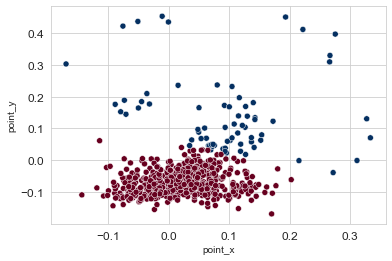

In [150]:
sns.scatterplot(data=relative_end, x="point_x", y="point_y",c=kmeans2.labels_,cmap="RdBu")

In [146]:
import collections
c = collections.Counter(kmeans.labels_)
display(c)
display([(i, c[i] / len(kmeans.labels_)) for i in c])

Counter({1: 73, 0: 551})

[(1, 0.11698717948717949), (0, 0.8830128205128205)]

Nach dem betrachten des eingefärbten Scatterplots - kategorisiert nach Cluster - lässt sich feststellen, dass der rote Cluster dicht besetzt, und der blaue Cluster sehr spärlich besetzt ist. Eine Ähnlichkeit zu Normaldaten und Anomalien ist erkennbar.

Der rote Cluster besteht aus 88,3% aller Punkte, dies bestätigt die These mit Normal- und Anomaliedaten.
Aus diesem Grund sehen wir nach der k-Means Clustermethode den Mittelpunkt des roten Clusters bei k=2 - also [ 0.01997886, -0.0663818 ] als den optimalen relativen Startpunkt.

Der relative Startpunkt sollte also um +0.20 mm auf der x-Achse und um -0.066mm auf der y-Achse verschoben werden.